# Mount Gdrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install required packages

In [3]:
!pip install obonet

In [4]:
!pip install Bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 24.2 MB/s eta 0:00:00


In [5]:
!pip install tensorflow==2.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 708.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 47.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existin

# Import Library

In [7]:
import numpy as np
import pandas as pd
import obonet
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from Bio import SeqIO

# Load Data

In [ ]:
# Load Data
fasta_path = '/content/drive/MyDrive/TA/Train/train_sequences.fasta'
terms_path = '/content/drive/MyDrive/TA/Train/train_terms.tsv'

fasta_data = pd.DataFrame([(record.id, str(record.seq)) for record in SeqIO.parse(fasta_path, "fasta")], columns=['Protein_ID', 'Sequence'])
terms_data = pd.read_csv(terms_path, sep='\t', header=None, names=['Protein_ID', 'GO_Term_ID', 'Ontology'])

print(fasta_data.shape)
print(terms_data.shape)

(142246, 2)
(5363864, 3)


In [ ]:
terms_data = terms_data[1:]
terms_data.head()

,Protein_ID,GO_Term_ID,Ontology
1,A0A009IHW8,GO:0008152,BPO
2,A0A009IHW8,GO:0034655,BPO
3,A0A009IHW8,GO:0072523,BPO
4,A0A009IHW8,GO:0044270,BPO
5,A0A009IHW8,GO:0006753,BPO


In [ ]:
# Memuat istilah GO dan namespace dari file OBO
go_graph = obonet.read_obo('/content/drive/MyDrive/TA/Train/go-basic.obo')

def get_namespace(go_id):
    if go_id in go_graph.nodes:
        return go_graph.nodes[go_id]['namespace']
    else:
        return 'unknown'

terms_data['Namespace'] = terms_data['GO_Term_ID'].apply(get_namespace)

# Menentukan nilai alpha untuk setiap jenis ontologi
alpha_values = {
    'biological_process': 0.59,
    'cellular_component': 0.46,
    'molecular_function': 0.55,
    'unknown': 0.5  # Atau nilai default lainnya
}

# Load PLM (Pre-Train ProtBERT)

In [ ]:
# Load Pre-trained ProtBERT embeddings
train_protein_ids = np.load('/content/drive/MyDrive/TA/embedding-ProtBERT2(PLM)/train_ids.npy')
train_protein_ids.shape

(142246,)

In [ ]:
# Convert to pandas DataFrame
protein_df = pd.DataFrame(train_protein_ids, columns=['Protein ID'])

In [ ]:
train_embeddings = np.load('/content/drive/MyDrive/TA/embedding-ProtBERT2(PLM)/train_embeddings.npy')

# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
trainProtBert_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(trainProtBert_df.shape)

trainProtBert_df

(142246, 1024)


,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.155392,0.035353,0.089697,-0.250368,0.248972,-0.032696,-0.073959,0.011419,-0.064566,-0.149671,...,-0.031426,-0.067552,-0.070645,-0.108290,0.036037,-0.180188,-0.099818,-0.039517,-0.073583,0.045931
1,-0.072053,0.093417,-0.002659,-0.005690,0.113906,-0.010813,-0.101786,0.021196,-0.012389,-0.028101,...,0.064644,-0.020896,-0.120009,-0.104604,-0.033123,0.030718,0.002714,-0.019167,-0.022672,0.072778
2,0.143780,0.019153,0.086995,-0.215061,0.219807,-0.028687,-0.101207,0.031871,-0.043015,-0.121149,...,-0.037286,-0.064872,-0.082310,-0.189828,0.027312,-0.189434,-0.097486,-0.054416,-0.042178,0.059392
3,-0.037358,0.007036,0.083136,-0.116788,-0.000758,-0.025243,-0.105427,0.070486,0.069643,-0.031957,...,0.103480,-0.023106,-0.105887,-0.105809,0.004708,-0.051759,-0.020586,-0.078935,-0.056303,0.011840
4,0.134157,0.035627,0.092638,-0.181336,0.196127,-0.028752,-0.089066,0.031362,-0.039287,-0.114085,...,-0.079311,-0.003805,-0.094771,-0.124049,-0.015014,-0.155916,-0.068633,-0.071746,-0.022954,0.034192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142241,0.147929,0.038236,0.088560,-0.186308,0.215773,-0.020082,-0.096748,0.025047,-0.042503,-0.134126,...,-0.108391,-0.005824,-0.103199,-0.129677,-0.014649,-0.183368,-0.080375,-0.078769,-0.026516,0.042059
142242,0.131828,0.054219,0.077887,-0.148568,0.224928,-0.022521,-0.123447,0.021245,-0.056433,-0.146565,...,-0.196388,0.050541,-0.114763,-0.071523,-0.074057,-0.159375,-0.049020,-0.104436,-0.025143,0.002702
142243,0.089361,0.011512,0.060914,-0.149445,0.049561,-0.019799,-0.057201,0.071967,0.096672,-0.026753,...,-0.109179,0.044166,-0.170318,-0.164218,0.040792,-0.024063,-0.021582,-0.056286,-0.030200,0.051646
142244,0.143351,0.017191,0.101269,-0.212221,0.226264,-0.027656,-0.094190,0.037489,-0.048261,-0.123396,...,-0.049111,-0.051377,-0.089795,-0.158856,0.013364,-0.199180,-0.089999,-0.072951,-0.050119,0.049581


# Preprocessing Data

In [ ]:
# Preprocessing Data
merged_data = pd.merge(terms_data, fasta_data[['Protein_ID', 'Sequence']], on='Protein_ID')
merged_data = merged_data[merged_data.Protein_ID.isin(train_protein_ids)]

In [ ]:
# Set the limit for label
num_of_labels = 1500

# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
labels = merged_data['GO_Term_ID'].value_counts().index[:num_of_labels].tolist()

In [ ]:
# Fetch the train_terms data for the relevant labels only
merged_data_updated = merged_data.loc[merged_data['GO_Term_ID'].isin(labels)]
merged_data_updated.nunique()

Protein_ID    142246
GO_Term_ID      1500
Ontology           3
Namespace          3
Sequence      138924
dtype: int64

In [ ]:
# Construct a binary matrix for labels
# i.e, train_size x num_of_labels (142246 x 1500)
train_size = train_protein_ids.shape[0] # len(X)
train_labels = np.zeros((train_size ,num_of_labels))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(train_protein_ids)

# Loop through each label
for i in range(10):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = merged_data_updated[merged_data_updated['GO_Term_ID'] ==  labels[i]]

    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['Protein_ID'].unique()

    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)

# Convert train_Y numpy into pandas dataframe
labels_df = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df.shape)

labels_df

(142246, 1500)


,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0034250,GO:0140053,GO:0031345,GO:0098802,GO:0045861,GO:0051783,GO:0001818,GO:0031674,GO:0006874,GO:0070828
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142241,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142242,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142243,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142244,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
protbert_ids = np.load('/content/drive/MyDrive/TA/embedding-ProtBERT2(PLM)/train_ids.npy')
protbert_embed = np.load('/content/drive/MyDrive/TA/embedding-ProtBERT2(PLM)/train_embeddings.npy')

In [ ]:
train_df = pd.DataFrame(protbert_embed)
train_df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.155392,0.035353,0.089697,-0.250368,0.248972,-0.032696,-0.073959,0.011419,-0.064566,-0.149671,...,-0.031426,-0.067552,-0.070645,-0.108290,0.036037,-0.180188,-0.099818,-0.039517,-0.073583,0.045931
1,-0.072053,0.093417,-0.002659,-0.005690,0.113906,-0.010813,-0.101786,0.021196,-0.012389,-0.028101,...,0.064644,-0.020896,-0.120009,-0.104604,-0.033123,0.030718,0.002714,-0.019167,-0.022672,0.072778
2,0.143780,0.019153,0.086995,-0.215061,0.219807,-0.028687,-0.101207,0.031871,-0.043015,-0.121149,...,-0.037286,-0.064872,-0.082310,-0.189828,0.027312,-0.189434,-0.097486,-0.054416,-0.042178,0.059392
3,-0.037358,0.007036,0.083136,-0.116788,-0.000758,-0.025243,-0.105427,0.070486,0.069643,-0.031957,...,0.103480,-0.023106,-0.105887,-0.105809,0.004708,-0.051759,-0.020586,-0.078935,-0.056303,0.011840
4,0.134157,0.035627,0.092638,-0.181336,0.196127,-0.028752,-0.089066,0.031362,-0.039287,-0.114085,...,-0.079311,-0.003805,-0.094771,-0.124049,-0.015014,-0.155916,-0.068633,-0.071746,-0.022954,0.034192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142241,0.147929,0.038236,0.088560,-0.186308,0.215773,-0.020082,-0.096748,0.025047,-0.042503,-0.134126,...,-0.108391,-0.005824,-0.103199,-0.129677,-0.014649,-0.183368,-0.080375,-0.078769,-0.026516,0.042059
142242,0.131828,0.054219,0.077887,-0.148568,0.224928,-0.022521,-0.123447,0.021245,-0.056433,-0.146565,...,-0.196388,0.050541,-0.114763,-0.071523,-0.074057,-0.159375,-0.049020,-0.104436,-0.025143,0.002702
142243,0.089361,0.011512,0.060914,-0.149445,0.049561,-0.019799,-0.057201,0.071967,0.096672,-0.026753,...,-0.109179,0.044166,-0.170318,-0.164218,0.040792,-0.024063,-0.021582,-0.056286,-0.030200,0.051646
142244,0.143351,0.017191,0.101269,-0.212221,0.226264,-0.027656,-0.094190,0.037489,-0.048261,-0.123396,...,-0.049111,-0.051377,-0.089795,-0.158856,0.013364,-0.199180,-0.089999,-0.072951,-0.050119,0.049581


# Bangun Model

In [ ]:
def precision(y_true, y_pred):
    y_pred_binary = K.cast(K.greater(y_pred, 0.5), dtype='float32')
    true_positives = K.sum(K.cast(K.equal(y_true * y_pred_binary, 1), dtype='float32'))
    predicted_positives = K.sum(y_pred_binary)
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_pred_binary = K.cast(K.greater(y_pred, 0.5), dtype='float32')
    true_positives = K.sum(K.cast(K.equal(y_true * y_pred_binary, 1), dtype='float32'))
    actual_positives = K.sum(y_true)
    recall = true_positives / (actual_positives + K.epsilon())
    return recall

In [ ]:
# Pastikan bentuk input yang benar untuk LSTM, yaitu [samples, timesteps, features]
TIMESTEPS = 16
INPUT_SHAPE = (TIMESTEPS, trainProtBert_df.shape[1] // TIMESTEPS)

In [ ]:
# Build model with fixed hyperparameters
def build_model():
    model = models.Sequential()
    model.add(layers.LSTM(units=128, return_sequences=True, input_shape=INPUT_SHAPE))
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.LSTM(units=64))
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.Dense(num_of_labels, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc'), precision, recall]
    )

    return model

In [ ]:
# Mengubah bentuk data train
train_data_reshaped = trainProtBert_df.values.reshape((-1, TIMESTEPS, INPUT_SHAPE[1]))
labels_data_reshaped = labels_df.values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_data_reshaped, labels_data_reshaped, test_size=0.2)

In [ ]:
# Build and train the model
model = build_model()
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16, 128)           98816     
                                                                 
 dropout (Dropout)           (None, 16, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1500)              9

# Save model

In [ ]:
# Muat model dengan custom_objects
model.save('/content/drive/MyDrive/TA/Result/Eksperimen4.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Save training history to CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/MyDrive/TA/Result/training_eksperimen4.csv', index=False)

# Evaluasi Model

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

# Define custom metric functions
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value

# Load model with custom_objects={'precision': precision, 'recall': recall}
loaded_model = load_model('/content/drive/MyDrive/TA/Result/Eksperimen4.h5',
                          custom_objects={'precision': precision, 'recall': recall})

In [ ]:
# Evaluasi model pada data validasi
eval_results = loaded_model.evaluate(X_val, y_val)

# Tampilkan hasil evaluasi
print("Loss:", eval_results[0])
print("Binary Accuracy:", eval_results[1])
print("AUC:", eval_results[2])
print("Precision:", eval_results[3])
print("Recall:", eval_results[4])

890/890 [==============================] - 23s 23ms/step - loss: 0.0042 - binary_accuracy: 0.9976 - auc: 0.9990 - precision: 0.6273 - recall: 0.6937
Loss: 0.0041982815600931644
Binary Accuracy: 0.9975828528404236
AUC: 0.9989827871322632
Precision: 0.627274751663208
Recall: 0.6937112808227539


# Visualisasi hasil metrik train

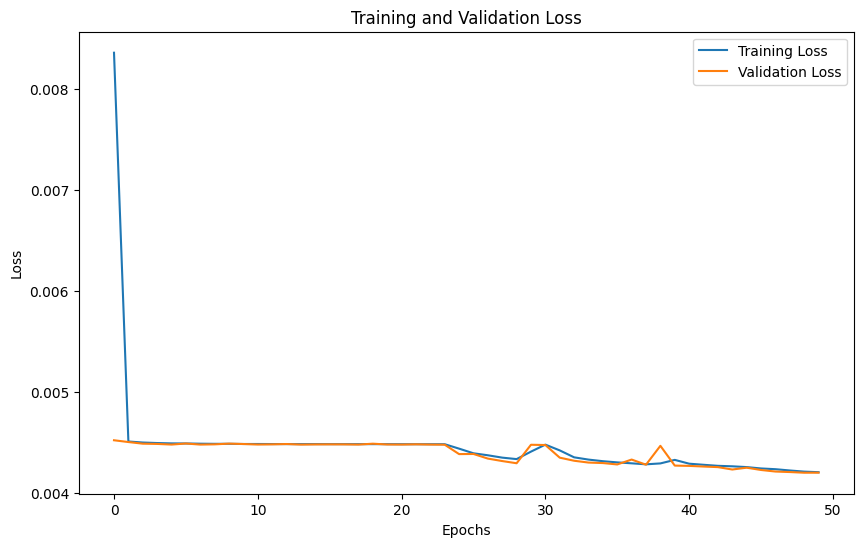

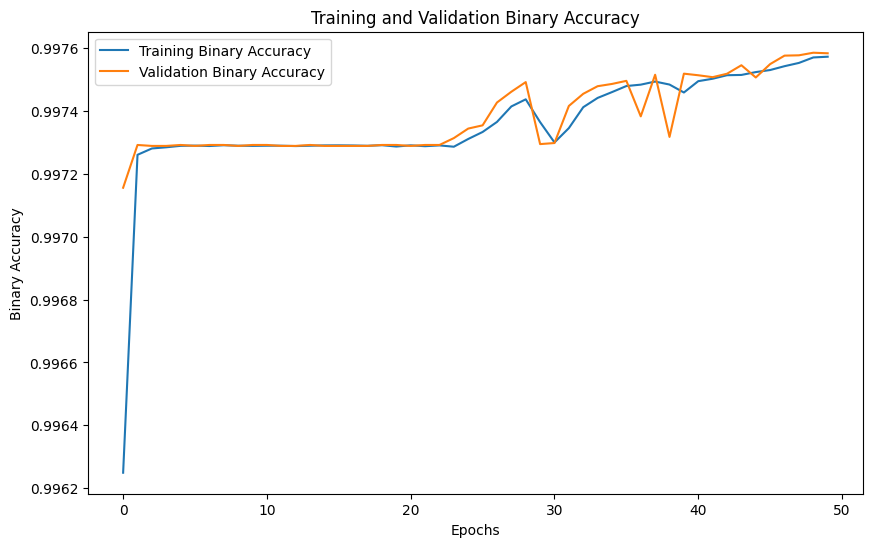

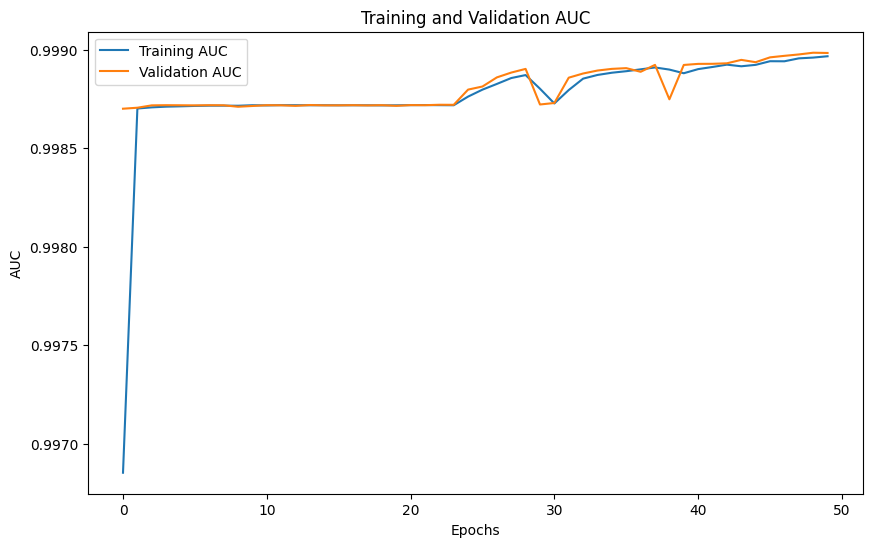

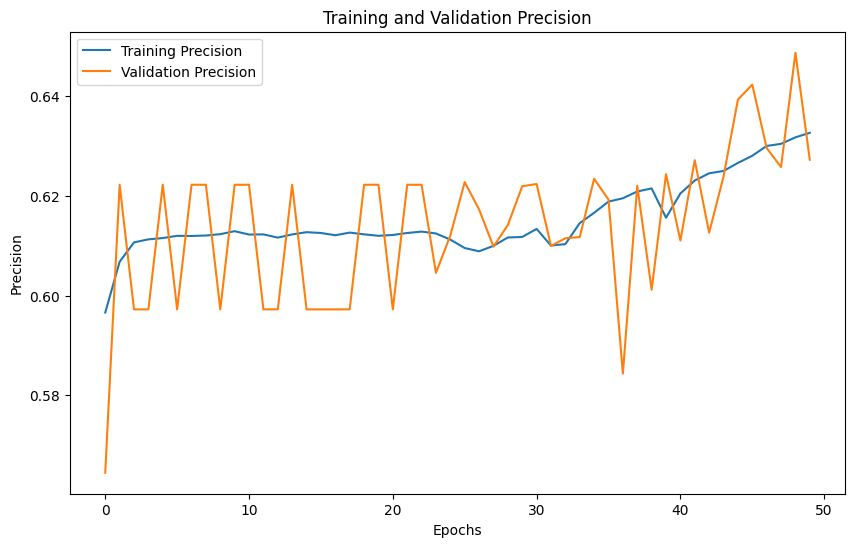

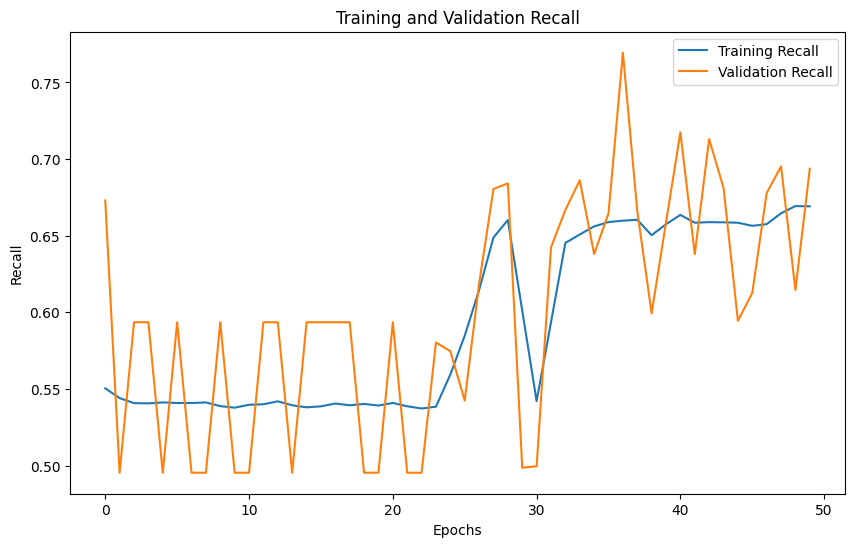

In [ ]:
import matplotlib.pyplot as plt

# Visualisasi hasil metrik train
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualisasi metrik binary accuracy
plt.figure(figsize=(10, 6))

plt.plot(history.history['binary_accuracy'], label='Training Binary Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Binary Accuracy')
plt.title('Training and Validation Binary Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.show()

# Visualisasi metrik AUC
plt.figure(figsize=(10, 6))

plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

# Visualisasi metrik Precision
plt.figure(figsize=(10, 6))

plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Visualisasi metrik Recall
plt.figure(figsize=(10, 6))

plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Prediksi

In [ ]:
# Memuat embeddings data test
test_embeddings = np.load('/content/drive/MyDrive/TA/embedding-ProtBERT2(PLM)/test_embeddings.npy')
test_df = pd.DataFrame(test_embeddings)
test_data_reshaped = test_df.values.reshape((-1, TIMESTEPS, INPUT_SHAPE[1]))

# Lakukan prediksi
predictions = model.predict(test_data_reshaped)

# Siapkan DataFrame untuk menyimpan hasil prediksi
df_predik3 = pd.DataFrame(columns=['Protein Id', 'GO Term Id', 'Prediction'])
test_protein_ids = np.load('/content/drive/MyDrive/TA/embedding-ProtBERT2(PLM)/test_ids.npy')
l = []
for k in list(test_protein_ids):
    l += [k] * predictions.shape[1]

df_predik3['Protein Id'] = l
df_predik3['GO Term Id'] = labels * len(test_protein_ids)
df_predik3['Prediction'] = predictions.ravel()

# Simpan hasil prediksi ke file
df_predik3.to_csv("/content/drive/MyDrive/TA/Result/PredikEksperimen4.tsv", header=False, index=False, sep="\t")

df_predik3

4434/4434 [==============================] - 82s 18ms/step


# Combine hasil predik LSTM+ProtBERT & Diamond_Search

In [ ]:
import pandas as pd
# Load hasil prediksi dari LSTM+ProtBERT
df_lstm_protbert = pd.read_csv('/content/drive/MyDrive/TA/Result/PredikEksperimen3-2.tsv', sep='\t', header=None, names=['Protein_ID', 'GO_Term_ID', 'Prediction'])

In [ ]:
import pandas as pd
# Load hasil prediksi dari Diamond Search
df_diamond = pd.read_csv('/content/drive/MyDrive/TA/Result/HasilPrediksi_Diamond.tsv', sep='\t', header=None, names=['Protein_ID', 'GO_Term_ID', 'Prediction'])

In [ ]:
df_lstm_protbert

,Protein_ID,GO_Term_ID,Prediction
0,Q9CQV8,GO:0005575,6.967045e-01
1,Q9CQV8,GO:0008150,7.608844e-01
2,Q9CQV8,GO:0110165,6.919226e-01
3,Q9CQV8,GO:0003674,6.153817e-01
4,Q9CQV8,GO:0005622,6.233931e-01
...,...,...,...
212797495,A0A3G2FQK2,GO:0001818,6.509040e-11
212797496,A0A3G2FQK2,GO:0031674,5.584781e-11
212797497,A0A3G2FQK2,GO:0051783,6.454089e-11
212797498,A0A3G2FQK2,GO:0051048,6.094243e-11


In [ ]:
df_diamond

,Protein_ID,GO_Term_ID,Prediction
0,A0A023PXF5,GO:0000722,0.700
1,A0A023PXF5,GO:0000723,0.700
2,A0A023PXF5,GO:0003674,0.500
3,A0A023PXF5,GO:0003678,0.500
4,A0A023PXF5,GO:0003824,0.500
...,...,...,...
23021978,X6R8R1,GO:1904580,0.062
23021979,X6R8R1,GO:1990769,0.062
23021980,X6R8R1,GO:2000241,0.062
23021981,X6R8R1,GO:2000300,0.125


In [ ]:
df_ds4 = df_lstm_protbert[df_lstm_protbert['Protein_ID']=='Q9CQV8']
df_ds4

,Protein_ID,GO_Term_ID,Prediction
0,Q9CQV8,GO:0005575,6.967045e-01
1,Q9CQV8,GO:0008150,7.608844e-01
2,Q9CQV8,GO:0110165,6.919226e-01
3,Q9CQV8,GO:0003674,6.153817e-01
4,Q9CQV8,GO:0005622,6.233931e-01
...,...,...,...
1495,Q9CQV8,GO:0001818,3.881538e-08
1496,Q9CQV8,GO:0031674,3.991543e-08
1497,Q9CQV8,GO:0051783,3.874519e-08
1498,Q9CQV8,GO:0051048,4.054177e-08


In [ ]:
df_ds3 = df_diamond[df_diamond['Protein_ID']=='P35213']
df_ds3

,Protein_ID,GO_Term_ID,Prediction
6099094,P35213,GO:0000003,0.125
6099095,P35213,GO:0000122,0.125
6099096,P35213,GO:0000132,0.062
6099097,P35213,GO:0000165,0.062
6099098,P35213,GO:0000226,0.125
...,...,...,...
6099560,P35213,GO:1903561,0.188
6099561,P35213,GO:1903828,0.062
6099562,P35213,GO:1904950,0.062
6099563,P35213,GO:1990849,0.062


# Combine 2 kolom yang memiliki Protein_ID dan GO_Term_ID yang berbeda

In [ ]:
# Menggabungkan data frame berdasarkan GO_Term_ID
merged_df1 = df_ds4.merge(df_ds3, on='GO_Term_ID', suffixes=('_lstm-protbert', '_diamond'))

In [ ]:
# Mengganti nama kolom untuk membedakan GO_Term_ID dari kedua metode
merged_df1 = merged_df1.rename(columns={
    'GO_Term_ID': 'GO_Term_ID_Lstm-ProtBERT',
    'Protein_ID_lstm-protbert': 'Protein_ID_Lstm-ProtBERT',
    'Prediction_lstm-protbert': 'Prediction_Lstm-ProtBERT',
    'Protein_ID_diamond': 'Protein_ID_Diamond',
    'Prediction_diamond': 'Prediction_Diamond'
})

In [ ]:
# Menyalin GO_Term_ID_Lstm-ProtBERT ke kolom GO_Term_ID_diamond untuk konsistensi penamaan
merged_df1['GO_Term_ID_Diamond'] = merged_df1['GO_Term_ID_Lstm-ProtBERT']

In [ ]:
# Mengatur urutan kolom agar lebih jelas
merged_df1 = merged_df1[['Protein_ID_Lstm-ProtBERT', 'GO_Term_ID_Lstm-ProtBERT', 'Prediction_Lstm-ProtBERT',
                         'Protein_ID_Diamond', 'GO_Term_ID_Diamond', 'Prediction_Diamond']]

In [ ]:
merged_df1

,Protein_ID_Lstm-ProtBERT,GO_Term_ID_Lstm-ProtBERT,Prediction_Lstm-ProtBERT,Protein_ID_Diamond,GO_Term_ID_Diamond,Prediction_Diamond
0,Q9CQV8,GO:0005575,6.967045e-01,P35213,GO:0005575,0.938
1,Q9CQV8,GO:0008150,7.608844e-01,P35213,GO:0008150,0.875
2,Q9CQV8,GO:0110165,6.919226e-01,P35213,GO:0110165,0.938
3,Q9CQV8,GO:0003674,6.153817e-01,P35213,GO:0003674,0.812
4,Q9CQV8,GO:0005622,6.233931e-01,P35213,GO:0005622,0.812
...,...,...,...,...,...,...
318,Q9CQV8,GO:0009994,3.783415e-08,P35213,GO:0009994,0.062
319,Q9CQV8,GO:0006887,3.793098e-08,P35213,GO:0006887,0.062
320,Q9CQV8,GO:0070372,3.830957e-08,P35213,GO:0070372,0.062
321,Q9CQV8,GO:0006457,3.828831e-08,P35213,GO:0006457,0.062


# S = (alpha * LSTM-ProtBERT) + (1-alpha) * Diamond)

In [ ]:
# Menghitung Combined Prediction
alpha = 0.5
merged_df1['Combined_Prediction'] = (alpha * merged_df1['Prediction_Diamond']) + ((1 - alpha) * merged_df1['Prediction_Lstm-ProtBERT'])

In [ ]:
# Pastikan bahwa kolom GO_Term_ID di terms_data_with_namespace memiliki tipe data yang sama dengan di merged_df1
terms_data_with_namespace = terms_data[['GO_Term_ID', 'Namespace']].drop_duplicates()
terms_data_with_namespace['GO_Term_ID'] = terms_data_with_namespace['GO_Term_ID'].astype(str)
merged_df1['GO_Term_ID_Lstm-ProtBERT'] = merged_df1['GO_Term_ID_Lstm-ProtBERT'].astype(str)

In [ ]:
# Menggabungkan dengan terms_data_with_namespace untuk mendapatkan Namespace
merged_df0 = merged_df1.merge(terms_data_with_namespace, left_on='GO_Term_ID_Lstm-ProtBERT', right_on='GO_Term_ID')

In [ ]:
merged_df0

,Protein_ID_Lstm-ProtBERT,GO_Term_ID_Lstm-ProtBERT,Prediction_Lstm-ProtBERT,Protein_ID_Diamond,GO_Term_ID_Diamond,Prediction_Diamond,Combined_Prediction,GO_Term_ID,Namespace
0,Q9CQV8,GO:0005575,6.967045e-01,P35213,GO:0005575,0.938,0.817352,GO:0005575,cellular_component
1,Q9CQV8,GO:0008150,7.608844e-01,P35213,GO:0008150,0.875,0.817942,GO:0008150,biological_process
2,Q9CQV8,GO:0110165,6.919226e-01,P35213,GO:0110165,0.938,0.814961,GO:0110165,cellular_component
3,Q9CQV8,GO:0003674,6.153817e-01,P35213,GO:0003674,0.812,0.713691,GO:0003674,molecular_function
4,Q9CQV8,GO:0005622,6.233931e-01,P35213,GO:0005622,0.812,0.717697,GO:0005622,cellular_component
...,...,...,...,...,...,...,...,...,...
318,Q9CQV8,GO:0009994,3.783415e-08,P35213,GO:0009994,0.062,0.031000,GO:0009994,biological_process
319,Q9CQV8,GO:0006887,3.793098e-08,P35213,GO:0006887,0.062,0.031000,GO:0006887,biological_process
320,Q9CQV8,GO:0070372,3.830957e-08,P35213,GO:0070372,0.062,0.031000,GO:0070372,biological_process
321,Q9CQV8,GO:0006457,3.828831e-08,P35213,GO:0006457,0.062,0.031000,GO:0006457,biological_process


# Simpan hasil kombinasi predik

In [ ]:
merged_df0.to_csv("/content/drive/MyDrive/TA/Result/Combined_Predictions_Different_Combination-update1.tsv", index=False, sep="\t")

In [ ]:
merged_df0

,Protein_ID_Lstm-ProtBERT,GO_Term_ID_Lstm-ProtBERT,Prediction_Lstm-ProtBERT,Protein_ID_Diamond,GO_Term_ID_Diamond,Prediction_Diamond,Combined_Prediction,GO_Term_ID,Namespace
0,Q9CQV8,GO:0005575,6.967045e-01,P35213,GO:0005575,0.938,0.817352,GO:0005575,cellular_component
1,Q9CQV8,GO:0008150,7.608844e-01,P35213,GO:0008150,0.875,0.817942,GO:0008150,biological_process
2,Q9CQV8,GO:0110165,6.919226e-01,P35213,GO:0110165,0.938,0.814961,GO:0110165,cellular_component
3,Q9CQV8,GO:0003674,6.153817e-01,P35213,GO:0003674,0.812,0.713691,GO:0003674,molecular_function
4,Q9CQV8,GO:0005622,6.233931e-01,P35213,GO:0005622,0.812,0.717697,GO:0005622,cellular_component
...,...,...,...,...,...,...,...,...,...
318,Q9CQV8,GO:0009994,3.783415e-08,P35213,GO:0009994,0.062,0.031000,GO:0009994,biological_process
319,Q9CQV8,GO:0006887,3.793098e-08,P35213,GO:0006887,0.062,0.031000,GO:0006887,biological_process
320,Q9CQV8,GO:0070372,3.830957e-08,P35213,GO:0070372,0.062,0.031000,GO:0070372,biological_process
321,Q9CQV8,GO:0006457,3.828831e-08,P35213,GO:0006457,0.062,0.031000,GO:0006457,biological_process
